In [1]:
from src.data import get_dataloaders
from src.model import RNA_net
from src.util import compute_f1, compute_precision, compute_recall, plot_structures
from src.submission_formatter import format_submission

import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
device

device(type='cuda')

In [3]:
train_loader, val_loader, test_loader = get_dataloaders(batch_size =64, max_length=110, split=0.8, max_data=6000)

In [4]:
# Init model, loss function, optimizer
embedding_dim = 64
model = RNA_net(embedding_dim).to(device)
loss = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor([300])).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
train_losses = []
test_losses = []
train_f1 = []
test_f1 = []
train_prece = []
test_prece = []
train_recall = []
test_recall = []

for epoch in range(25):
    train_loss = 0.0
    test_loss = 0.0
    train_metric = 0.0
    test_metric = 0.0
    train_met_prece = 0.0
    test_met_prece = 0.0
    train_met_recall = 0.0
    test_met_recall = 0.0
    
    # Training loop
    for batch in train_loader:

        #set to gpu
        x = batch['sequence'].to(device)
        y = batch['structure'].to(device)
        
        y_pred = model(x)
        l = loss(y_pred, y)

        # Optimization
        optimizer.zero_grad()
        l.backward()
        optimizer.step()

        # Metrics
        train_loss += l.item()
        
        train_metric += compute_f1(y_pred, y)
        train_met_prece += compute_precision(y_pred, y)
        train_met_recall += compute_recall(y_pred, y)

# Validation loop
    for batch in val_loader:

        #set to gpu
        x = batch['sequence'].to(device)
        y = batch['structure'].to(device)
        
        with torch.no_grad(): 
            y_pred = model(x)
            l = loss(y_pred, y)

        # Metrics
        test_loss += l.item()
        test_metric += compute_f1(y_pred, y)
        test_met_prece += compute_precision(y_pred, y)
        test_met_recall += compute_recall(y_pred, y)
        
    # Log and print
    train_losses.append(train_loss/len(train_loader))
    test_losses.append(test_loss/len(val_loader))
    
    
    train_f1.append(train_metric/len(train_loader))
    test_f1.append(test_metric/len(val_loader))

    train_prece.append(train_met_prece/len(train_loader))
    test_prece.append(test_met_prece/len(val_loader))

    train_recall.append(train_met_recall/len(train_loader))
    test_recall.append(test_met_recall/len(val_loader))
    
    print(f'Epoch {epoch} TRAIN::: loss: {train_losses[-1]:.3f}  F1: {train_f1[-1]:.2f}   Precision: {train_prece[-1]:.2f}  Recall: {train_recall[-1]:.2f}')
    print(f'Epoch {epoch} VALIDATION::: loss: {test_losses[-1]:.3f}  F1: {test_f1[-1]:.2f}   Precision: {test_prece[-1]:.2f}  Recall: {test_recall[-1]:.2f}')
    print()



Epoch 0 TRAIN::: loss: 0.286  F1: 0.21   Precision: 0.12  Recall: 0.96
Epoch 0 VALIDATION::: loss: 0.123  F1: 0.26   Precision: 0.15  Recall: 0.98

Epoch 1 TRAIN::: loss: 0.097  F1: 0.36   Precision: 0.22  Recall: 0.98
Epoch 1 VALIDATION::: loss: 0.077  F1: 0.42   Precision: 0.26  Recall: 0.98

Epoch 2 TRAIN::: loss: 0.067  F1: 0.44   Precision: 0.28  Recall: 0.99
Epoch 2 VALIDATION::: loss: 0.083  F1: 0.53   Precision: 0.37  Recall: 0.98

Epoch 3 TRAIN::: loss: 0.056  F1: 0.49   Precision: 0.33  Recall: 0.99
Epoch 3 VALIDATION::: loss: 0.065  F1: 0.53   Precision: 0.36  Recall: 0.98

Epoch 4 TRAIN::: loss: 0.040  F1: 0.56   Precision: 0.39  Recall: 0.99
Epoch 4 VALIDATION::: loss: 0.065  F1: 0.57   Precision: 0.40  Recall: 0.98

Epoch 5 TRAIN::: loss: 0.036  F1: 0.59   Precision: 0.42  Recall: 0.99
Epoch 5 VALIDATION::: loss: 0.050  F1: 0.60   Precision: 0.43  Recall: 0.99

Epoch 6 TRAIN::: loss: 0.033  F1: 0.60   Precision: 0.43  Recall: 0.99
Epoch 6 VALIDATION::: loss: 0.053  F1: 0.

## plots

In [5]:
import matplotlib.pyplot as plt

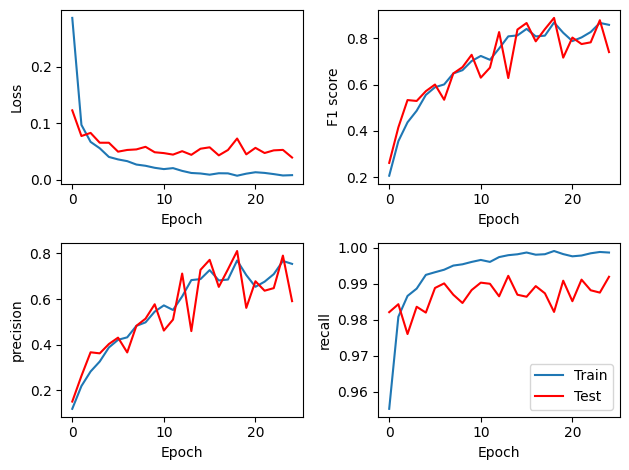

In [6]:
fig, (ax1, ax2)  = plt.subplots(2, 2)

ax1[0].plot(train_losses, label='Train')
ax1[0].plot(test_losses, label='Test', color='red')
ax1[0].set_xlabel('Epoch')
ax1[0].set_ylabel('Loss')

ax1[1].plot(train_f1, label='Train')
ax1[1].plot(test_f1, label='Test', color='red')
ax1[1].set_xlabel('Epoch')
ax1[1].set_ylabel('F1 score')

ax2[0].plot(train_prece, label='Train')
ax2[0].plot(test_prece, label='Test', color='red')
ax2[0].set_xlabel('Epoch')
ax2[0].set_ylabel('precision')

ax2[1].plot(train_recall, label='Train')
ax2[1].plot(test_recall, label='Test', color='red')
ax2[1].set_xlabel('Epoch')
ax2[1].set_ylabel('recall')

plt.legend()
plt.tight_layout()
plt.show()

In [9]:
# Test loop
structures = []
for sequence in test_loader[1]:
    # Replace with your model prediction !
    structure = (model(sequence.to(device).unsqueeze(0)).squeeze(0)>0.5).type(torch.int) # Has to be shape (L, L) ! 
    structures.append(structure)

format_submission(test_loader[0], test_loader[1], structures, 'test_pred.csv')